# 1. Environment Setting

## (1) Import Modules

In [1]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## (2) Support Function for binalization

### 1) OtsuThreshold

In [2]:
def OtsuThreshold(img):
    maxval = np.max(img)
    vectimg = np.reshape(img,[img.shape[0]*img.shape[1],])
    histData = np.uint8(np.zeros([maxval+1,1]))
    for i in vectimg:
        histData[i]=histData[i]+1
    
    total = vectimg.shape[0]
    sum_ = 0
    for i in range(256): 
        sum_ = sum_+ i*histData[i]
        
    sumB = 0
    wB = 0
    wF = 0
    varMax = (float)(0)
    threshold = 0;
    for i in range(256):
        wB = wB + histData[i]
        if(wB==0):
            continue
        wF = total-wB;
        if(wF==0):
            break
        sumB = sumB + i*histData[i]
        mB = sumB/(float)(wB)
        mF = (sum_-sumB)/(float)(wF)
        varBetween = wB*wF*(mB-mF)*(mB-mF)
        if(varBetween>varMax):
            varMax = varBetween
            threshold = i
    binaryim = np.uint8(np.zeros(img.shape))
    binaryim[img>threshold] = 255;
    return binaryim

### 2) C-means Clustering

In [3]:
# Function based C_means Clustering
def LUT2label(im,LUT):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    L = np.zeros([im.shape[0],im.shape[1]],dtype=int)
    for k in range(np.max(LUT)+1):
        i = np.where(LUT==k)[0]
        i1 = int(i[0])
        
        if(i.size>1):
            i2=int(i[-1])
        else:
            i2=i1
        
        bw = np.where((im>I[i1]) & (im<I[i2]))
        for j in range(bw[0].size):
            L[bw[0][j],bw[1][j]] = k

    return L
 
# C_means Clustering    
def FastCmeans(im,c=2):
    Imin = np.min(im)
    Imax = np.max(im)
    I =np.array(range(Imin,Imax+1))
    I = I.reshape([I.shape[0],1])
    H = np.zeros([I.shape[0],1],dtype=int)
    k = im.shape[0]*im.shape[1]
    imshap =im.shape
    im = im.reshape([im.shape[0]*im.shape[1],1])
    for i in range(k):
        H[im[i]-Imin]=H[im[i]-Imin]+1 
        
    dl=(Imax-Imin)/c
    C=np.arange(Imin+dl/2,Imax,dl)
    IH = np.multiply(H,I)
    dC = float("inf")
    
    while(dC>1e-6):
        C0 =C
        D = np.ndarray([I.shape[0],0])
        for i in range(C.shape[0]):
            D = np.concatenate((D,np.subtract(I,C[i])),axis=1)
        
        D = np.abs(D)
        LUT = np.argmin(D,axis=1)
        C = np.double(C)
        for i in(range(c)):
            C[i]=np.sum(np.uint(IH[LUT==i]))/np.sum(np.uint(H[LUT==i]))
            
        dC = np.max(np.abs(np.subtract(C,C0))) 

    L =LUT2label(im,LUT)
    L = L.reshape(imshap)
    return L

## (2) Read Test Image

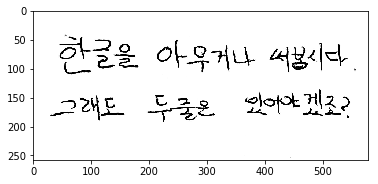

In [4]:
imag = cv2.imread("Test2.jpg",0)
imag = cv2.resize(imag,(imag.shape[1]/4,imag.shape[0]/4),interpolation=cv2.INTER_CUBIC)
plt.imshow(imag,'gray')
plt.show()

# 2. Preprocessing

## (1) Reverse Image for Morphism

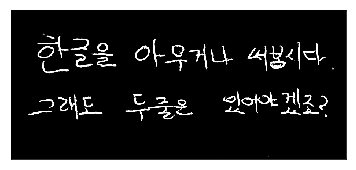

In [5]:
imag = np.uint8(np.ones(imag.shape)*255-imag)
rows,cols= imag.shape
plt.imshow(imag,cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## (2) Binalization

### 1) Fast-Cmeans clustering

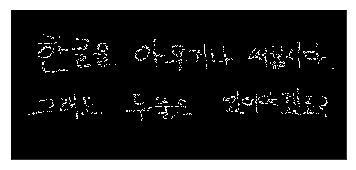

In [6]:
L = FastCmeans(imag)
onenum = np.where(L==1)[0].size
zeronum = np.where(L==0)[0].size
if(onenum>zeronum):
    L=np.ones(L.shape)- L
Cmeans = np.float32(np.multiply(L,255))

plt.imshow(Cmeans,'gray')
#plt.title('Fast-Cmeans Clustering')
plt.xticks([])
plt.yticks([])
plt.show()

### 2) Otsu-Threshold

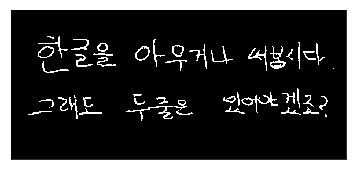

In [7]:
Otsuimag = OtsuThreshold(imag)
plt.imshow(Otsuimag,'gray')
#plt.title('OtsuThreshold')
plt.xticks([])
plt.yticks([])    
plt.show()

### 3) Adaptive Gaussian Threshold

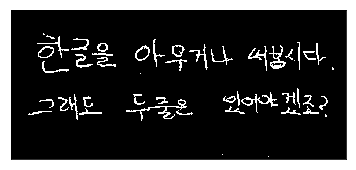

In [8]:
gaussian = cv2.adaptiveThreshold(np.uint8(np.ones(imag.shape)*255-imag),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
gaussian = np.ones(gaussian.shape)*255-gaussian
plt.imshow(gaussian,'gray')
#plt.title('Adaptive Gaussain Threshold')
plt.xticks([])
plt.yticks([])
plt.show()

## (3) Closing For Binary Image

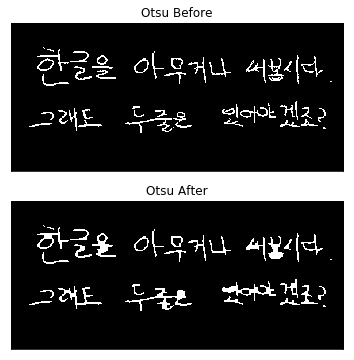

In [9]:
kernel = np.ones((5,5),np.uint8)

Otsu_closing = cv2.morphologyEx(Otsuimag,cv2.MORPH_CLOSE,kernel)


images = [Otsuimag,Otsu_closing]
titles = ['Otsu Before','Otsu After']
plt.figure(figsize=(10,6))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

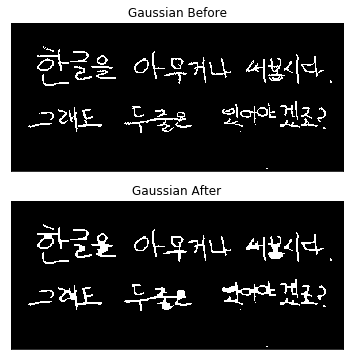

In [10]:
kernel = np.ones((5,5),np.uint8)
Gaussian_closing = cv2.morphologyEx(gaussian,cv2.MORPH_CLOSE,kernel)
images = [gaussian,Gaussian_closing]
titles = ['Gaussian Before','Gaussian After']
plt.figure(figsize=(10,6))
for i in range(2):
    plt.subplot(2,1,i+1)
    plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

# 3. Text-line Segmentation

## Find strip-width

In [11]:
binaryimg = np.uint8(Otsu_closing/255)
imagesum = np.sum(binaryimg)/(float)(rows*cols)
stripwidth = 0
if(imagesum>=0.2):
    stripwidth = 0.05*cols
elif(imagesum>0.1):
    stripwidth = 0.1*cols
else:
    stripwidth = 0.25*cols

stripwidth = int(math.ceil(stripwidth))

In [12]:
math.floor(cols/stripwidth)

3.0

## Projection to y axis

In [13]:
proj = np.zeros([rows,int(math.ceil(cols/(float)(stripwidth)))])
rangemat = range(0,cols,stripwidth)
for i in xrange(0,cols/stripwidth):
    proj[:,i]=np.sum(Otsu_closing[:,rangemat[i]:rangemat[i]+stripwidth-1],axis=1)    
    
proj[:,-1] = np.uint(np.sum(Otsu_closing[:,rangemat[i+1]:],axis=1))

proj2 = np.zeros([proj.shape[0]+9,proj.shape[1]])
proj2[4:-5,:]= proj
for i in range(rows):
    proj[i,:] = np.sum(proj2[i-4:i+5,:],axis=0)
    
proj = proj/9
x = range(proj.shape[0])
alpha = 10;

threshold = np.sum(proj,axis = 0)/(alpha*rows)



## result of Adjust Threshold

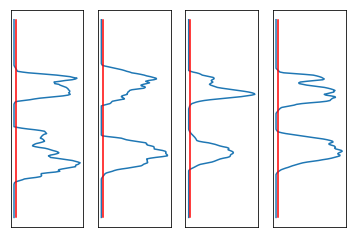

In [14]:
for i in xrange(len(rangemat)):
    plt.subplot(1,len(rangemat),i+1)
    plt.plot(proj[:,i],x)
    plt.plot(np.ones(proj[:,i].shape)*threshold[i],x,'r-')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Calculate Above Boundary and Below Boundary

In [15]:
AB = np.array([])
BB = np.array([])

for j in range(rows):
    if(proj[j,0]>threshold[0] and proj[j-1,0]<=threshold[0]):
        AB = np.concatenate((AB,[j-2]))
    if(proj[j,0]>threshold[0] and proj[j+1,0]<=threshold[0]):
        BB = np.concatenate((BB,[j+2]))

BBi = np.uint8(np.zeros(BB.shape))
ABi = np.uint8(np.ones(AB.shape)*rows)
        
for i in range(1,len(rangemat)):
    BBi = np.zeros(BBi.shape)
    ABi = np.ones(ABi.shape)*rows
    A_i = 0
    B_i = 0
    for j in range(rows):
        if(proj[j,i]>threshold[i] and proj[j-1,i]<=threshold[i]):
            ABi[A_i] = j-2
            A_i += 1
        if(proj[j,i]>threshold[i] and proj[j+1,i]<=threshold[i]):
            BBi[B_i] = j+2
            B_i += 1
            
    AB = np.vstack((AB,ABi))
    BB = np.vstack((BB,BBi))


## Seperate TextLine

In [16]:
D = np.sum((np.abs(np.subtract(AB,BB))))/AB.nonzero()[0].shape[0]
#
#AB = AB.reshape([len(rangemat),AB.shape[0]/len(rangemat)])
#BB = BB.reshape([len(rangemat),BB.shape[0]/len(rangemat)])

minAB = np.uint8(np.min(AB,axis=0))
maxBB = np.uint8(np.max(BB,axis=0))
linenum = maxBB.shape[0]
rowmax = np.max(maxBB-minAB)

image_sep = np.uint8(np.zeros([linenum,rowmax,cols]))
image_sepb = np.uint8(np.zeros([linenum,rowmax,cols]))

AB = np.uint8(AB)
BB = np.uint8(BB)
for i in range(linenum):
    for j in range(len(rangemat)):
        image_sep[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = imag[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]
        image_sepb[i,AB[j,i]-minAB[i]:BB[j,i]-minAB[i],rangemat[j]:rangemat[j]+stripwidth-1] = Otsuimag[AB[j,i]:BB[j,i],rangemat[j]:rangemat[j]+stripwidth-1]


### Result

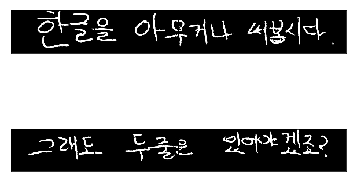

In [17]:
for i in range(image_sep.shape[0]):
        plt.subplot(image_sep.shape[0],1,i+1)
        plt.imshow(image_sep[i,:,:],'gray')
        plt.xticks([])
        plt.yticks([])

plt.show()

# Coarse Segmentation with SWT

## Stroke Width Transform

In [18]:
def swt(source):
    result = cv2.distanceTransform(source,cv2.cv.CV_DIST_L2,5)
    minVal,maxVal,minLoc,maxLoc=cv2.minMaxLoc(result)
    strokeradius = np.uint8(np.ceil(maxVal))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
    for i in xrange(strokeradius):
        result=cv2.dilate(result,kernel)
        result = np.multiply(result,source)
    
    return result

Ge Target and AW

In [19]:
target = image_sepb[0,:,:]/255

In [20]:
swt_image = swt(np.uint8(target))

In [21]:
AW = np.sum(swt_image)/np.sum(target)

y projection with target_closing image and divide it  by AW

In [22]:
target_c =  cv2.morphologyEx(target,cv2.MORPH_CLOSE,kernel)
y_proj = np.sum(target_c,axis=0)

y_proj2 = np.zeros([y_proj.shape[0]+5,])

In [23]:
cols = target.shape[0]
rows = target.shape[1]
y_proj2[2:-3] = y_proj
for i in range(rows):
    y_proj[i] = np.sum(y_proj2[i-2:i+3])/5 # smoothing projection

Result for Coarse Segmentation using AW

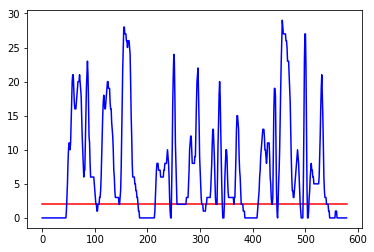

In [24]:
plt.plot(xrange(y_proj.shape[0]),np.ones(y_proj.shape)*round(AW),'r-')
plt.plot(xrange(y_proj.shape[0]),y_proj,'b')
plt.show()


Fine Segmentation process with Labeling

In [25]:
RB = 0
LB = 0
target[:,np.where(y_proj<round(AW))[0]] = 0
RowBoundary = np.where(y_proj<round(AW))[0]
componentlabel =0
changeflag = np.zeros([2,],np.uint8)

In [26]:
from skimage import measure

In [27]:
for i in xrange(1,len(RowBoundary)-1):
    if(RowBoundary[i]+1 != RowBoundary[i+1]):
        if(RB != RowBoundary[i]):
            changeflag[0] = 1
            RB = RowBoundary[i]
    if(RowBoundary[i]-1 != RowBoundary[i-1]):
        if(LB != RowBoundary[i]):
            changeflag[1] = 1
            LB = RowBoundary[i]
    if((RB<LB)&(np.sum(changeflag)==2)):
        print("Lmin is %d " %i)
        changeflag= changeflag*0
        tempimg = target[:,RB:LB]
        L = measure.label(tempimg)
        L[L!=0] +=componentlabel
        for j in xrange(L.min()+1,L.max()+1):
            tempcomp =set(np.where(L==j)[1])
            if(np.where(L==j)[1].shape[0]<=20):  ## denoise small component
                L[L==j] = 0
            else:
                componentlabel +=1
                L[L==j] = componentlabel
                for k in xrange(j+1,L.max()+1):
                    tempcomp2 = set(np.where(L==k)[1])
                    if(len(tempcomp)*2./3 < len((tempcomp&tempcomp2))):  ## if projection area is overlapped more than 2/3, merege component
                        L[L==k]=componentlabel        
        target[:,RB:LB]=L


Lmin is 47 
Lmin is 49 
Lmin is 81 
Lmin is 84 
Lmin is 89 
Lmin is 92 
Lmin is 120 
Lmin is 122 
Lmin is 127 
Lmin is 130 


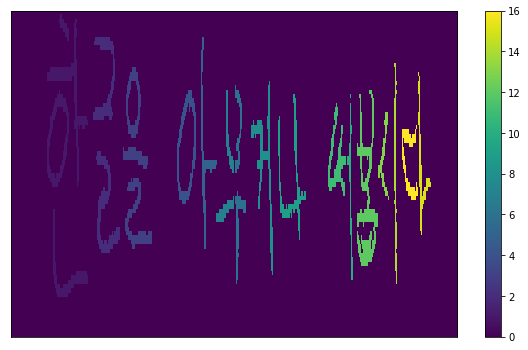

In [28]:
plt.figure(figsize=(10,6))
plt.imshow(target, aspect='auto', interpolation='none') ## result of fine segmentation
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

help funcion to show fine segmentation

In [29]:
def textshow(i,target):
    tempimg = np.zeros(target.shape)
    tempimg[target==i]=255
    plt.imshow(tempimg,aspect='auto')

# Merge  component with Wierd Clustering

In [30]:
from sklearn import metrics

classnum = target.max()
gapdist= np.ones([classnum,3])*1000


for i in xrange(1,classnum+1):
    for j in xrange(1,classnum+1):
        if(j!=i):
            Xcenter = [[np.sum(np.where(target==i)[0])/np.where(target==i)[0].shape[0],np.sum(np.where(target==i)[1])/np.where(target==i)[0].shape[0]]]
            Ycenter = [[np.sum(np.where(target==j)[0])/np.where(target==j)[0].shape[0],np.sum(np.where(target==j)[1])/np.where(target==j)[0].shape[0]]]
            eucmetmin = metrics.pairwise.euclidean_distances(Xcenter,Ycenter).min()
            if(eucmetmin<gapdist[i-1,1]):
                gapdist[i-1,0] = j
                gapdist[i-1,1] = eucmetmin
                gapdist[i-1,2] = np.where(target==i)[0].shape[0] + np.where(target==j)[0].shape[0]

from sklearn import cluster                
model = cluster.AgglomerativeClustering()
pred=model.fit_predict(gapdist[:,1:])
componentlabel =0
target_d = target

for i in xrange(pred.shape[0]):
    if((pred[i]==0)&(gapdist[(int)(gapdist[i,0]-1),0] == i+1)):
        if(i+1>gapdist[i,0]):
            componentlabel+=1
            target_d[target_d == i+1] = componentlabel
            target_d[target_d == gapdist[i,0]] = componentlabel 
    else:
        componentlabel+=1
        target_d[target_d==i+1] = componentlabel
        

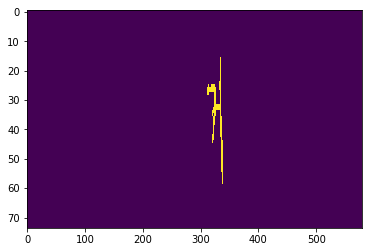

In [36]:
textshow(6,target_d)